# Neuromodulator Imaging Analysis

Here's some instructions from Alex on Friday 15/09:

- Simulate a train of APs of neurons: assuming a spike every second, then scale it to faster, then addd jitter/Poisson distribution — try drawing from an exp distribution or flip a coin each time
- Simulate relationship btn APs and DA release
- Simulate the signal delta F/ F

In this notebook, we will simulate the dynamics of neuromodulator concentration. For this we will start with:
- Simulation of a firing neuron, 
- Translate that to release of a neuromodulator. 
- Followed by a simulation of the signal $\Delta F/F$ produced by the changes in neuromodulator concentration.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp

### 1.Simulation of firing neuron

Here, we define a function that simulates the activity of one neuron and takes the number of timesteps of activity as an argument.

In [2]:
# define function that simulates a firing neuron

# it takes the number of timesteps as the argument
def simulate_neuron(n_timesteps):
    
    # Start with an array of the timesteps that we're recording from
    firing_neuron = np.zeros(n_timesteps)

    # Then populate the array with signals - firing & not firing -- with a specific probability that you choose
    for i in range(n_timesteps):
        x = np.random.rand()

        # firing with probability of 1/1000 at each time bin
        if x < 0.001:
            firing_neuron[i]=1

    # then make a plot of it!
    plt.plot(firing_neuron)
    plt.xlabel('timesteps')
    plt.ylabel('Neuron activity')
    plt.title('Neuron Activity over {} timesteps'.format(n_timesteps))
    plt.show()
  

    return firing_neuron



Now let's visualize our firing neuron to see if we simulated it correctly

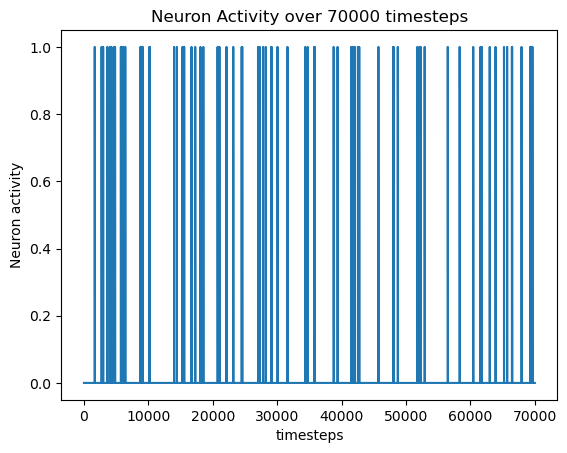

In [3]:
# define the number of timesteps 70 seconds - 70000 milliseconds
# each timestep / bin is 1 ms wide

firing_neuron = simulate_neuron(70000)

In [10]:
firing_neuron.size


70000

Ok, look's like the neuron is firing as we expect it to over 70,000 timesteps


Below is an alternative approach to generating the spiking activity of a neuron, that makes use of the signal.unit_impulse feature of scipy.

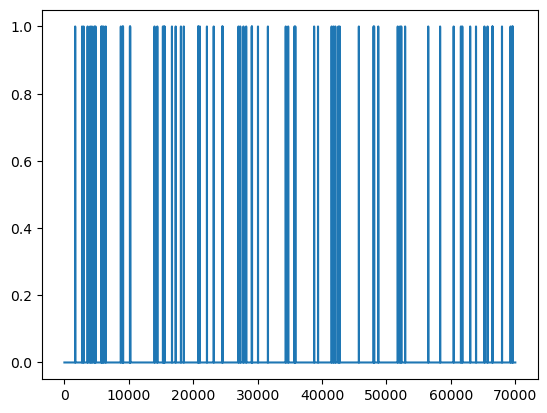

In [5]:
# timesteps where the neuron fired
firing_timesteps = np.nonzero(firing_neuron)

# generate visual representation of a train of spikes / I'll use this as the first approx. for the changes in [NM]
# ideally for the changes in [NM], we'd like to produce a chain of decaying exponents -- hopefully we produce them in a later cell

n_timesteps =70000
spike_train = sp.signal.unit_impulse(n_timesteps,idx=firing_timesteps)

plt.plot(spike_train)

### 2.Neuromodulator concentration

Now let's simulate a simple case of neuromodulator release caused by our firing neuron. Here, we assume that the neuromodulator release occurs instantaneously, and that we are dealing with one compartment and there's no uptake. 

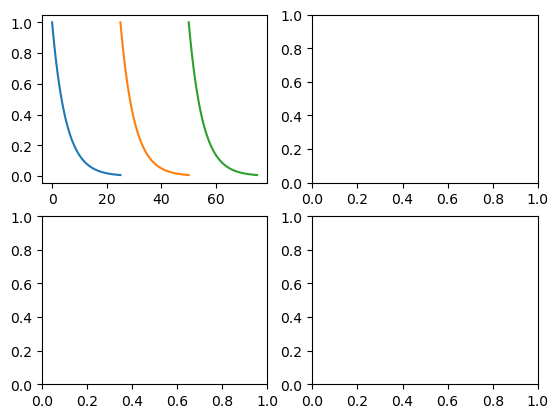

In [6]:
# The logic: each time the neuron fires, a spike appears this is followed by an explonential decay
# try to plot a series of exponentials

fig, ax = plt.subplots(2,2)

z = np.arange(100)
z1 = np.linspace(0,25)
z2 = np.linspace(25,50)
z3 = np.linspace(50,75)
tau_prime = 5
ax[0,0].plot(z1,np.exp(-z1/tau_prime))
ax[0,0].plot(z2,np.exp(-(z1)/tau_prime))
ax[0,0].plot(z3,np.exp(-(z1)/tau_prime))

Ok, so the above simple simulation of the chain of transients didn't work too well. Let's try a different approach


Below, we make a function to simulate the changes in neuromodulator concentration, [NM], caused by the firing neuron. These transients are calculated based on an equation modelling calcium dynamics (Ca2+ Buffering and Action Potential-Evoked Ca2+ Signaling in Dendrites of Pyramidal Neurons by Fritjof Helmchen,et. al) :

\Delta [Ca^{2+}](n \Delta t) = A \Sum_{i=1}^n \exp^{-(i\Delta t)/\tau} = A (\Sum^n_{i=1}(\exp^{-\Delta t/\tau})^i - 1) = \frac{A}{(\exp^{\Delta t/\tau} - 1)} (1 - \exp^{-n \Delta t /\tau}) 

This equation shows the [Ca^{2+}]_i level above resting immediately before the (n+1)-th action potential.

We are going to assume that the dynamics governing the NM is the same, so to get [NM], we will replace [Ca^{2+}] with it. 


In [17]:
# takes as input the activity of a neuron over a given number of timesteps
# and returns a plot showing corresponding changes in [NM] 

def nm_transients(neuron_activity):

    # timesteps where the neuron fired
    firing_timesteps = np.nonzero(neuron_activity)

    # the time between the start and the first action potential
    dt_0 = np.array([firing_timesteps[0][0]])

    # array of the intervals between the firing timesteps
    dt_sequence = np.diff(firing_timesteps)

    # Include the time interval for the 1st action potential
    dt_sequence = np.concatenate((dt_0,dt_sequence.flatten()), axis=0)

    # convert dt to seconds so that we don't get infinities/zeros
    dt_sequence_s = dt_sequence/1000

    # length of dt_seq
    length_dt = np.size(firing_timesteps)


    # constants to plug into the equation from the paper -- CHECK W KENTA
    tau = 5
    A = 100
    n = length_dt

    # [NM] transients caused by the neuron firing - equation 7
    transients = (A/(np.exp(dt_sequence_s / tau) - 1)) * (1 - np.exp(-n*dt_sequence_s / tau))

    # find the highest and lowest change in concentration recorded:
    nm_max = np.max(transients)
    nm_min = np.min(transients)

    # Plot NM transients vs time:

    # make an array with the [NM] at all the timesteps,
    # including the timesteps at which spikes/transients were recorded
    nm_conc = np.zeros(neuron_activity.size)
    nm_conc[firing_timesteps] = transients

    # plot the [NM] at all timesteps -- 1st plot
    n_timesteps = neuron_activity.size
    t = np.linspace(0,n_timesteps-1,n_timesteps)

    plt.plot(t,nm_conc)
    plt.xlabel('time (ms)')
    plt.ylabel('NM concentration')
    plt.title('NM concentration across {} timesteps'.format(neuron_activity.size))
    plt.show()


    # generate sequence of numbers to use in plot to compare the different transients
    n_spikes = np.size(firing_timesteps)
    z4 = np.linspace(0,n_spikes-1,n_spikes)

    #plot each of the transients side by side in sequential order 
    # this second plot is just a check -- not necessary
    
    plt.plot(z4,transients)
    plt.xlabel('n (Action potential number)')
    plt.ylabel('NM concentration')
    plt.title('NM transients due to neuron firing')
    plt.show()


    # returns the smallest and largest transient (delta [NM]) and the [NM] at all times
    return nm_max, nm_min, nm_conc


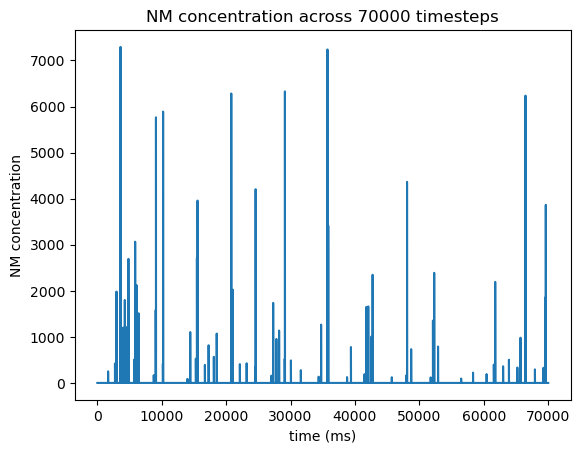

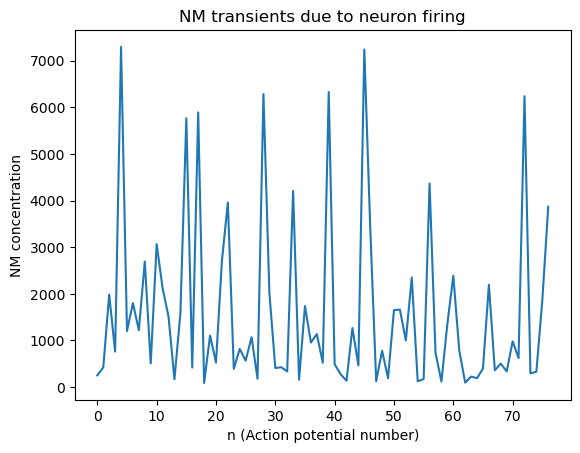

7294.381556139979 88.51592612624961


In [20]:
nm_max, nm_min, nm_conc = nm_transients(firing_neuron)
print(nm_max,nm_min)

The second plot above enables easy comparison of the different spikes' magnitude. 
The function also returns the largest and smallest recorded transient.

### 3.Flourescence Signal

Now, let's simulate the flourescence signal produced by the changes in the neuromodulator concentration,[NM]. This is described by eq. 3 in the calcium dynamics paper earlier mentioned: ** insert equation here

In [21]:
# GET ACTUAL VALUES FROM KENTA

# function takes in 3 constants used in the equation to calculate F:
    # 1.The dissociation constant for the NM binding to the sensor,K_D
    # 2.The fluorescence when sensor is completely unbound to NM, F_max
    # 3.The fluorescence when sensor is completely bound to NM

def flourescence_signal(K_D, F_max, F_min, nm_conc):

    # define K_D prime as
    K_Dp = K_D*(F_max/F_min)

    # the initial/steady state concentration, [NM]i,0, of the neuromdultor
    # CONFIRM VALUE FROM KENTA
    nm_conc_io = 0 

    # define the numerator and denominator
    numerator = (K_Dp + nm_conc)/(K_D + nm_conc)
    denominator = (K_Dp + nm_conc_io)/(K_D + nm_conc_io)

    # derive delta f/f0 by plugging in
    delta_f_f0 = (numerator/denominator) - 1

    # create timesteps array for the plot
    n_timesteps = nm_conc.size
    t = np.linspace(0,n_timesteps-1,n_timesteps)

    # plot the normalized signal delta f/f0 at the different t
    plt.plot(t,delta_f_f0)
    plt.xlabel('time(ms)')
    plt.ylabel('Delta F/F0')
    plt.title('Flourescence intensity signal over time')


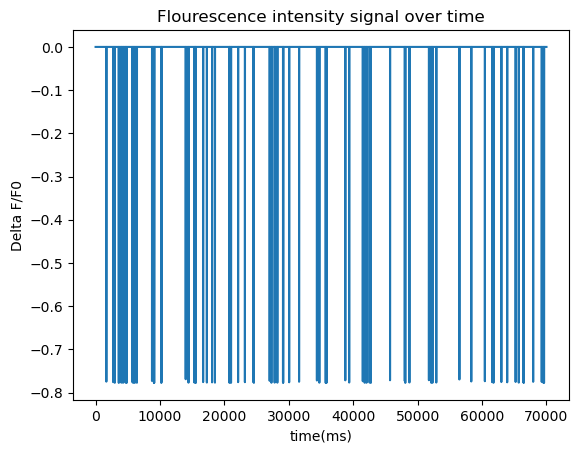

In [22]:
flourescence_signal(K_D = 1, F_max = 45, F_min = 10, nm_conc=nm_conc)